In [10]:
import torch, networkx as nx, torch_geometric, numpy as np, random, calflops
from torch_geometric.nn import GCNConv, GATConv
device = torch.device('cuda:0')

In [11]:
g1 = nx.read_graphml('msg_big_0.graphml')
g2 = nx.read_graphml('msg_big_1.graphml')
NUM_PROCS=16
NUM_EPOCHS = 1000
NUM_EXPS = 50

In [19]:
len(g1.nodes)

660

In [12]:
class GCNEncoder(torch.nn.Module):

    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(GCNEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_size)
        self.conv2 = GATConv(hidden_size, out_channels)

    # Our model will take the feature matrix X and the edge list
    # representation of the graph as inputs.
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        # x = self.dropout(x)
        return self.conv2(x, edge_index)

In [13]:
model = torch_geometric.nn.GAE(GCNEncoder(10, 512, 16, 0.0)).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
amg_loss_curve = []

In [14]:
def get_encodings(graphs):
    e_i_arr = [nx.to_scipy_sparse_array(g1, format='coo') for g1 in graphs]
    values = [e_i.data for e_i in e_i_arr]
    indices = [np.vstack((e_i.row, e_i.col)) for e_i in e_i_arr]
    e_i = [torch.sparse_coo_tensor(indices=indices[i], values = values[i], size=(len(graphs[i].nodes), len(graphs[i].nodes))).to(device).coalesce() for i in range(len(graphs))]
    # MPI Dict
    mpi_dict = {"MPI_Init": 0, 'MPI_Barrier': 1, 'MPI_Waitall': 2, 'MPI_Isend':3, 'MPI_Finalize':4, 'MPI_Send':5, 'MPI_Irecv':6, 'MPI_Recv':7, 'MPI_Wait':8}
    # Feature matrix gen
    #X = np.zeros((len(g1.nodes), 10+NUM_PROCS))
    X = [np.zeros((len(graphs[i].nodes), 10)) for i in range(len(graphs))]
    l = [list(graphs[i].nodes) for i in range(len(graphs))]
    d = [dict(graphs[i].nodes(data=True)) for i in range(len(graphs))]
    #p_id_arr = [[i for i in range(NUM_PROCS)]]
    #random.shuffle(p_id_arr)
    for j, k in enumerate(l):
        for i, n in enumerate(k):
            X[j][i][0] = d[j][n]['logical_time']
            X[j][i][mpi_dict[d[j][n]['mpi_function']]] = 1
            #X[i][int(10+p_id_arr[int(d[n]['process_id'])])] = 1
    X = [torch.tensor(X[i]).to(device).float() for i in range(len(X))]
    def train():
        model.train()
        losses = [0 for i in range(len(graphs))]
        for i, g in enumerate(graphs):
            optimizer.zero_grad()
            z = model.encode(X[i], e_i[i])
            loss = model.recon_loss(z, e_i[i].indices())
            loss.backward(retain_graph=True)
            optimizer.step()
            losses.append(float(loss))
        return losses
    for epoch in range(NUM_EPOCHS):
        l = train()
        if epoch%10 == 0:
            amg_loss_curve.append(l[2])
    z = [model.encode(X[i], e_i[i]) for i in range(len(graphs))]
    return z, model

e1, enc1 = get_encodings(g1)
e2, enc2 = get_encodings(g2)

nodes_1 = list(g1.nodes)
nodes_2 = list(g2.nodes)
for i, n in enumerate(e1):
    min_error = float('inf')
    k = torch.kron(torch.ones(len(g1.nodes)).to(device), n).view(len(g1.nodes), -1)
    res = (k-e2)**2
    M[nodes_1[i]].append(nodes_2[int(torch.sum(res, 1).argmin())])

In [15]:
align_ac = []
encs = []
for i in range(1):
    #e1, enc1 = get_encodings(g1)
    #e2, enc2 = get_encodings(g2)
    e, enc = get_encodings([g1, g2])
    M = {i:[] for i in g1.nodes}
    nodes_1 = list(g1.nodes)
    nodes_2 = list(g2.nodes)
    for i, n in enumerate(e[0]):
        min_error = float('inf')
        k = torch.kron(torch.ones(len(g1.nodes)).to(device), n).view(len(g1.nodes), -1)
        res = (k-e[1])**2
        M[nodes_1[i]].append(nodes_2[int(torch.sum(res, 1).argmin())])
    corr = 0
    for i in M:
        if i in M[i]:
            corr += 1
    align_ac.append(corr/len(M))


In [16]:
align_ac

[0.7181818181818181]

In [17]:
import pandas as pd, matplotlib.pyplot as plt

In [18]:
dat = pd.DataFrame({'MCB Grid': loss_curve, 'AMG2013':amg_loss_curve})

NameError: name 'loss_curve' is not defined

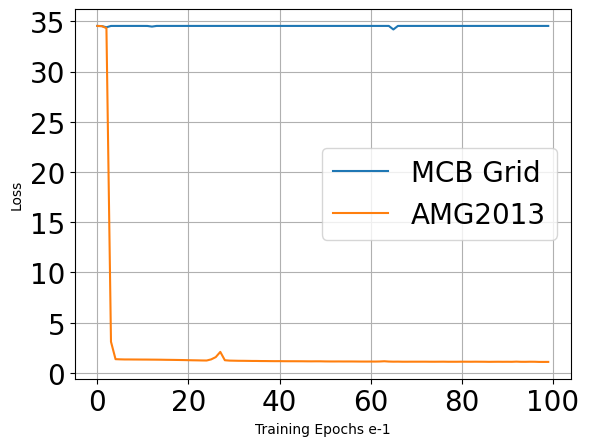

In [ ]:
dat.plot(grid=True, fontsize=20, legend=True, ylabel='Loss', xlabel='Training Epochs e-1' ).legend(fontsize=20)

[]